
Figure 1: each subplot gives a sample function from the
prior model, with some synthetic noisy observations.
This figure is meant to give you some idea of what the
different bandwidths imply.

Figure 2: each subplot gives some data from one of the
models. In gray are some posterior samples -- plausible
explanations of the data -- assuming the short
bandwidth. In red are some posterior samples assuming
the long bandwidth. The posterior probability of the
short-bandwidth is shown for each dataset.

For data generated with the short bandwidth, the long
bandwidth samples are bunched up despite not matching
the data -- we are too confident. This problem is
partly caused by fixing the noise level sigma_y.

For data generated with the long bandwidth, the short
bandwidth model ignores the smooth trend, and makes
rapidly fluctuating predictions. Fortunately this model
is deemed to be improbable, so we can ignore it.

You may have noticed that some of the plots show the
short bandwidth posterio

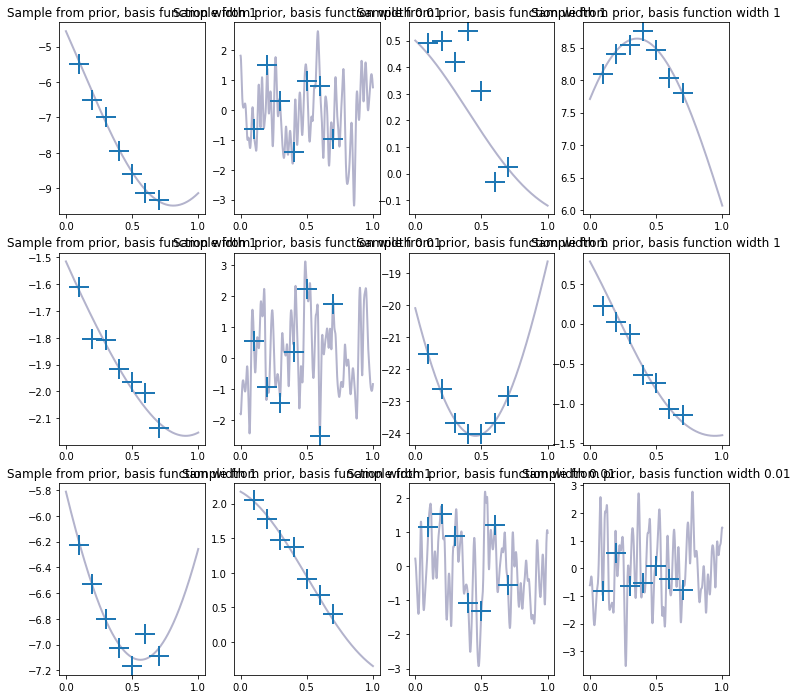

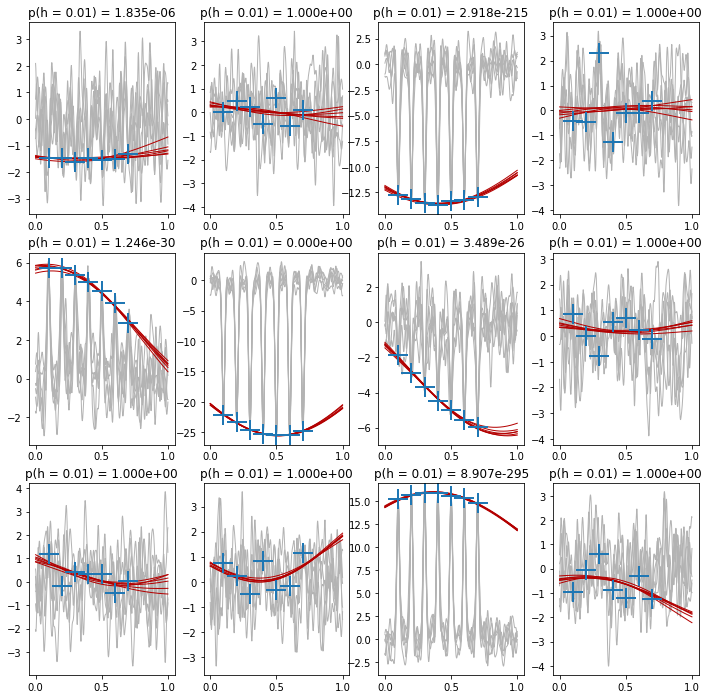

In [4]:
# Bayesian linear regression demo
#
# This demo will use RBF basis functions. We assume the only unknowns
# are the weights and the width of the basis functions. To keep the
# discussion simpler, we assume everything else is known. Even though in
# reality there are many other "hyper-parameters" -- model choices that
# I have plucked out of thin air, and in reality could be questioned.
#
# I've written this quickly as a demonstration to accompany a lecture.
# It is not production code. I have also not checked it in any way. It
# is highly likely to contain mistakes!
#
# A good way to run it, so you get both plots and can then poke around:
# ipython --pylab
# %run blr_demo.py
#
# Iain Murray, November 2017

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla

VERBOSE = True

def blr(X, yy, sigma_w, sigma_y):
    """Bayesian linear regression, posterior and log marginal likelihood.
    
    Assume spherical zero-mean prior, with width sigma_w
    Return posterior mean w_N, chol(inv(V_N)) where V_N is posterior
    covariance, and log-marginal-likelihood.

    We use upper-triangular Cholesky's throughout (scipy.linalg's default).
    """
    N, D = X.shape
    inv_V_N = ((sigma_y/sigma_w)**2 * np.eye(D) + np.dot(X.T, X)) / sigma_y**2
    chol_inv_V_N = sla.cholesky(inv_V_N)
    w_N = sla.cho_solve((chol_inv_V_N, False), np.dot(X.T, yy)) / sigma_y**2
    # Evaluate p(w), p(y|X,w), p(w|y,X) at w=0. Hence get p(y|X)
    hl2pi = 0.5*np.log(2*np.pi)
    Lp_w0 = -D*(hl2pi + np.log(sigma_w))
    Lp_y_w0 = -0.5*np.dot(yy, yy)/sigma_y**2 - N*(hl2pi + np.log(sigma_y))
    U_w_N = np.dot(chol_inv_V_N, w_N)
    Lp_w0_yX = -0.5*np.dot(U_w_N, U_w_N) \
            - D*hl2pi + np.sum(np.log(np.diag(chol_inv_V_N)))
    Lml = Lp_w0 + Lp_y_w0 - Lp_w0_yX
    return (w_N, chol_inv_V_N, Lml)

def rbfs(X, K, hh):
    #  X N,1 inputs
    #  K number of RBFS
    # Returns Phi(X), where Phi has K RBFs of width hh, spaced between 0 and 1
    assert(X.shape[1] == 1) # Assuming one dimensional inputs.
    cc = np.linspace(0, 1, K)[None,:]
    return np.exp(-(X - cc)**2 / hh**2)

x_grid = np.linspace(0, 1, 1000)   # inputs used for plotting functions
x_train = np.linspace(0.1, 0.7, 7) # not modelled, assumed known
sigma_y = 0.1                      # std. dev. of Gaussian obs. noise
sigma_w = 1.0                      # std. dev. of 0-mean weight prior
K = 100                            # number of RBF basis functions

# Decide which bandwidths to consider, assign them colors for the second plot,
# and pre-compute input features for each bandwidth.
bandwidths = [0.01, 1]
colors = [[0.7]*3, [0.7, 0, 0]]
Phi_h = []
Phi_grid_h = []
for hh in bandwidths:
    Phi_h.append(rbfs(x_train[:,None], K, hh))
    Phi_grid_h.append(rbfs(x_grid[:,None], K, hh))

# FIRST PLOT
if VERBOSE: print("""
Figure 1: each subplot gives a sample function from the
prior model, with some synthetic noisy observations.
This figure is meant to give you some idea of what the
different bandwidths imply.""")
plt.figure(1, figsize=(12,12)); plt.clf()
num_rows = 3
num_cols = 4
num_subplots = num_rows * num_cols
for ii in range(num_subplots):
    h_idx = int(np.floor(np.random.rand() * len(bandwidths)))
    hh = bandwidths[h_idx]
    plt.subplot(num_rows, num_cols, ii+1)
    plt.title('Sample from prior, basis function width %g' % hh)
    ww = sigma_w * np.random.randn(K)
    f_grid = np.dot(Phi_grid_h[h_idx], ww)
    f_train = np.dot(Phi_h[h_idx], ww)
    y_train = f_train + sigma_y*np.random.randn(f_train.size)
    plt.plot(x_grid, f_grid, '-', linewidth=2, color=(0.7,0.7,0.8))
    plt.plot(x_train, y_train, '+', markersize=20, mew=2)

# SECOND PLOT
if VERBOSE: print("""
Figure 2: each subplot gives some data from one of the
models. In gray are some posterior samples -- plausible
explanations of the data -- assuming the short
bandwidth. In red are some posterior samples assuming
the long bandwidth. The posterior probability of the
short-bandwidth is shown for each dataset.""")
plt.figure(2, figsize=(12,12)); plt.clf()
for ii in range(num_subplots):
    plt.subplot(num_rows, num_cols, ii+1)

    # Generate synthetic data
    h_idx = int(np.floor(np.random.rand() * len(bandwidths)))
    w_true = sigma_w * np.random.randn(K)
    f_train = np.dot(Phi_h[h_idx], w_true)
    y_train = f_train + sigma_y*np.random.randn(f_train.size)

    Lmls = np.zeros(len(bandwidths))
    for h_idx in range(len(bandwidths)):
        w_N, chol_inv_V_N, Lml = blr(Phi_h[h_idx], y_train, sigma_w, sigma_y)
        Lmls[h_idx] = Lml
        num_samples = 6
        w_samples = w_N[:,None] + sla.solve_triangular(chol_inv_V_N, \
                np.random.randn(K, num_samples))
        w_samples = w_N[:,None] + np.dot(sla.inv(chol_inv_V_N), \
                np.random.randn(K, num_samples))
        f_samples = np.dot(Phi_grid_h[h_idx], w_samples)
        for ss in range(num_samples):
            plt.plot(x_grid, f_samples[:,ss], '-', lw=1, color=colors[h_idx])

    # Plot data last, so not obscured by lines:
    plt.plot(x_train, y_train, '+', markersize=20, mew=2)

    # Infer which bandwidth used:
    if len(bandwidths) == 2:
        # only implemented special case for two bandwidths:
        posterior_h_1 = 1 / (1 + np.exp(-(Lmls[0] - Lmls[1])))
        plt.title('p(h = %g) = %0.3e' % (bandwidths[0], posterior_h_1))

if VERBOSE: print("""
For data generated with the short bandwidth, the long
bandwidth samples are bunched up despite not matching
the data -- we are too confident. This problem is
partly caused by fixing the noise level sigma_y.

For data generated with the long bandwidth, the short
bandwidth model ignores the smooth trend, and makes
rapidly fluctuating predictions. Fortunately this model
is deemed to be improbable, so we can ignore it.

You may have noticed that some of the plots show the
short bandwidth posterior samples reaching out to the
data with a series of spikes. Because the narrow basis
functions don''t overlap as much, larger weights are
needed to get large function values. We could alter the
width of the prior, sigma_w, so that the narrow
bandwidth model is also happy with large function
values.
""")

plt.show()